# Lab 2, Part B: Simple Neural Nets in PyTorch

- Our goal in this lab is to introduce/review the basic PyTorch data prep process and training loop, and then train several variations on regression and classification models.
- We will create some DataSets and DataLoaders as well.
- We will also implement a few custom Layers, Activation functions, etc.
- Finally, we'll implement a simple autoencoder and practice transfer learning.

In [68]:
## Basic libraries needed:

#!pip install torch torchvision torchaudio
#!pip install scikit-learn
#!pip install -U numpy
#!pip install --upgrade numpy
#!pip install --upgrade matplotlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#Some PyTorch stuff:
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

## Part 1: DataSets and DataLoaders

- We will use the processed `mpg` dataset provided: There are several continuous and several one-hot encoded categorical features; the outputs are `cty` and `hwy`. As a somewhat contrived exercise, do the following:

Create a class called `FileDataset` that is a child of the parent class `Dataset`. This class should open a csv file of a given name, and return the features and target for the given (integer) index.  Your template is:

```
class FileDataset(Dataset):
    def __init__(self, filename, feature_cols, target_cols, mean=None, sd=None):
        ...
        
    def __getitem__(self, index):
        ...
        
    def __len__(self):
        ...
```

Construct the `__init__` method such that the Dataset is created like so:

```
my_dataset = FileDataset(filename, feature_columns, target_columns, mean, sd)
```

That is, pass the name of the file, a list of column names for the features, and a column name for the single target. `mean` should be a list of feature means, and `sd` is a list of feature standard deviations. *You will need to calculate appropriate means and standard devations for the continous features. Use `mean=0` and `sd=1` for one-hot encoded categorical features.*

Given this setup, construct `__getitem(self, index)__` such that a float32 tensor of features and a float32 tensor of target values is returned, as a tuple. Moreover, the features should be normalized according to the `mean` and `sd` arrays.


In [69]:
class FileDataset(Dataset):
    def __init__(self, filename, feature_cols, target_cols, mean=None, sd=None):
        ##load dataset from csv file
        self.data = pd.read_csv(filename)
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        
        ##mean/SD for normalization
        self.mean = mean
        self.sd = sd
        
        ##calculate mean/SD for continuous features
        if mean is None or sd is None:
            self.mean = self.data[feature_cols].mean().tolist()
            self.sd = self.data[feature_cols].std().tolist()

    def __getitem__(self, index):
        ##features for given index
        features = self.data.loc[index, self.feature_cols].values.astype(float)
        target = self.data.loc[index, self.target_cols].values.astype(float)
        
        ##normalize
        normalized_features = (features - self.mean) / self.sd
        
        ##convert to float32 tensors
        features_tensor = torch.tensor(normalized_features, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)
        
        return features_tensor, target_tensor

    def __len__(self):
        ##return total number of samples in dataset
        return len(self.data)

### Create training, validation, and testing `FileDataset`s from `mpg_processed.csv`

1. Create a `FileDataset` from `mpg_processed.csv`, using all columns except `cty` and `hwy` as features, and `hwy` as your target. *You will need to determine appropriate means and standard deviations for the continuous features.*

Confirm it loaded correctly by inspecting the first few entries.

2. Divide your dataset into training, validation, and testing datasets. Use 20% of the dataset for testing. Of the 80% allocated to training, split off 10% of this for validation. Be sure to randomize the train/validation/test split, but use a fixed random number seed so your work is reproducible.

In [70]:
df = pd.read_csv('mpg_processed.csv')

print(df.head())

##define feature columns/target column
target_column = 'hwy'
feature_columns = df.columns[df.columns != target_column].tolist()  # All columns except 'hwy'

##means/SD for features
mean = df[feature_columns].mean().tolist()
sd = df[feature_columns].std().tolist()

##create dataset
full_dataset = FileDataset('mpg_processed.csv', feature_columns, [target_column], mean, sd)

##sizes for the splits
total_size = len(full_dataset)
test_size = int(total_size * 0.2)
train_val_size = total_size - test_size
val_size = int(train_val_size * 0.1)
train_size = train_val_size - val_size

##random seed for reproducibility
torch.manual_seed(42)

##split dataset train/validation/test
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

##sizes of the datasets
print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

   cyl  displ  year  cty  hwy  class_2seater  class_compact  class_midsize  \
0    4    1.8  1999   18   29            0.0            1.0            0.0   
1    4    1.8  1999   21   29            0.0            1.0            0.0   
2    4    2.0  2008   20   31            0.0            1.0            0.0   
3    4    2.0  2008   21   30            0.0            1.0            0.0   
4    6    2.8  1999   16   26            0.0            1.0            0.0   

   class_minivan  class_pickup  class_subcompact  class_suv  drv_4  drv_f  \
0            0.0           0.0               0.0        0.0    0.0    1.0   
1            0.0           0.0               0.0        0.0    0.0    1.0   
2            0.0           0.0               0.0        0.0    0.0    1.0   
3            0.0           0.0               0.0        0.0    0.0    1.0   
4            0.0           0.0               0.0        0.0    0.0    1.0   

   drv_r  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
Tr

## Make DataLoaders:

- Create a DataLoader for each of the datasets above. Set the batch size for the training loader to 16, and `shuffle=True`.
- Set the batch size for the validation and training dataloaders to the length of the associated dataset; set `shuffle=False`
- Check the first few batches of the training DataLoader to confirm it works

Name your DataLoaders `train_loader`, `valid_loader`, and `test_loader`.

In [71]:
##dataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

##first batches of training
for features, targets in train_loader:
    print("Features batch shape:", features.shape)
    print("Targets batch shape:", targets.shape)
    break 

Features batch shape: torch.Size([16, 14])
Targets batch shape: torch.Size([16, 1])


## Create a Fully Connected Regression Model

- Let's build a simple regression model using PyTorch

- Create a class for a regerssion model inherited from the nn.Module class: name it `MyRegressor`; the class should also have two functions as in the following format:

```
class MyRegressor(nn.Module):
    def __init__(...):
        ...
        
    def forward(...):
        ...
```

- This model should consist of three hidden Linear layers of size 128, 64, and 32, an appropriate output layer.
- Use a ReLU activation function for all hidden Linear layers.

In [72]:
class MyRegressor(nn.Module):
    def __init__(self, input_size):
        super(MyRegressor, self).__init__()
        
        ##define layers
        self.hidden1 = nn.Linear(input_size, 128)
        self.hidden2 = nn.Linear(128, 64)        
        self.hidden3 = nn.Linear(64, 32)           
        self.output = nn.Linear(32, 1)       
        
        ##activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.output(x)
        return x

## Construct model, define training loop, and train

Now, you'll need to create a model of class `MyRegressor`, define a loss function and optimizer, and then train the model for a given number of epochs.

- Use Mean Square Error for your loss function
- Use an Adam Optimizer with a learning rate of $.01$.

Then:

- Train the model for 20 epochs
- Calculate the validation loss and training loss for each epoch: Note that the training loss should be calculated as the average for each batch, while the validation loss is calculated at the end of the epoch
- Plot these losses as a function of epoch number; you should get something like the following:

In [73]:
##model/loss function/optimizer
input_size = len(feature_columns)
model = MyRegressor(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

##training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for features, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))

    ##validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for features, targets in valid_loader:
            outputs = model(features)
            loss = criterion(outputs, targets.view(-1, 1))
            epoch_val_loss += loss.item()
    
    val_losses.append(epoch_val_loss / len(valid_loader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

Epoch 1/20, Train Loss: 372.2737, Validation Loss: 154.2647
Epoch 2/20, Train Loss: 72.0512, Validation Loss: 37.9410
Epoch 3/20, Train Loss: 21.2947, Validation Loss: 5.3689
Epoch 4/20, Train Loss: 9.4434, Validation Loss: 7.5738
Epoch 5/20, Train Loss: 5.7858, Validation Loss: 6.3136
Epoch 6/20, Train Loss: 3.2116, Validation Loss: 3.2028
Epoch 7/20, Train Loss: 2.5190, Validation Loss: 2.6177
Epoch 8/20, Train Loss: 1.7617, Validation Loss: 2.5747
Epoch 9/20, Train Loss: 1.6138, Validation Loss: 2.8907
Epoch 10/20, Train Loss: 1.5296, Validation Loss: 3.1740
Epoch 11/20, Train Loss: 1.6404, Validation Loss: 3.0016
Epoch 12/20, Train Loss: 1.4476, Validation Loss: 2.7224
Epoch 13/20, Train Loss: 1.2727, Validation Loss: 2.4413
Epoch 14/20, Train Loss: 1.1794, Validation Loss: 2.3306
Epoch 15/20, Train Loss: 1.2352, Validation Loss: 2.0810
Epoch 16/20, Train Loss: 1.4043, Validation Loss: 2.6416
Epoch 17/20, Train Loss: 1.4297, Validation Loss: 1.5452
Epoch 18/20, Train Loss: 1.3925, 

### Plot and score predictions on both training and test sets

- Generate predictions for both the training and testing datasets
- Plot the predicted values against the true values
- Report both $R^2$ values (these should both be around 85%)

Your results should resemble the following:

Training R^2: -1.0034
Testing R^2: 0.9288


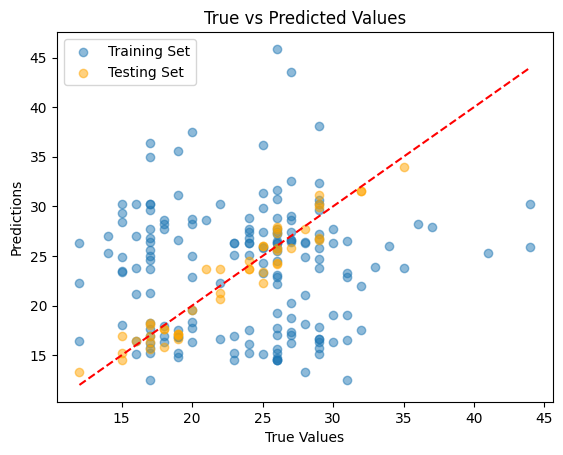

In [74]:
from sklearn.metrics import r2_score

##predictions training/testing datasets
model.eval()

train_predictions = []
train_targets = []

with torch.no_grad():
    for features, targets in train_loader:
        outputs = model(features)
        train_predictions.append(outputs)

train_predictions = torch.cat(train_predictions).numpy()
train_targets = torch.cat([targets.view(-1, 1) for features, targets in train_loader]).numpy()

##predictions
test_predictions = []
test_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        test_predictions.append(outputs)

test_predictions = torch.cat(test_predictions).numpy()
test_targets = torch.cat([targets.view(-1, 1) for features, targets in test_loader]).numpy()

##R^2 scores
train_r2 = r2_score(train_targets, train_predictions)
test_r2 = r2_score(test_targets, test_predictions)

print(f'Training R^2: {train_r2:.4f}')
print(f'Testing R^2: {test_r2:.4f}')

##plot predicted values/true values
plt.scatter(train_targets, train_predictions, alpha=0.5, label='Training Set')
plt.scatter(test_targets, test_predictions, alpha=0.5, label='Testing Set', color='orange')
plt.plot([min(train_targets), max(train_targets)], [min(train_targets), max(train_targets)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import r2_score

##predictions training/testing datasets
model.eval()

train_predictions = []
train_targets = []

with torch.no_grad():
    for features, targets in train_loader:
        outputs = model(features)
        train_predictions.append(outputs)

train_predictions = torch.cat(train_predictions).numpy()
train_targets = torch.cat([targets.view(-1, 1) for features, targets in train_loader]).numpy()


## Initialization Schemes

Let's try a few different initialization schemes. By default, PyTorch initializes a Linear layer (`torch.nn.Linear()`) by drawing both weights and biases from:

$$
\text{Uniform}\left(-\frac{1}{\sqrt{n_{in}}}, \frac{1}{\sqrt{n_{in}}}\right),
$$
where $n_{in}$ is the number of input features/neurons.

Our goal in backpropagating neural nets is to avoid the vanishing and exploding gradients problems. When running a net in the forward direction, we want the variance of the outputs of each layer is similar to the variance of the inputs. When backpropagating the error signal, we want the variance of the gradients to be similar before and after passing through each layer.

Glorot and Bengio (2010) showed that an alternative weight initialization scheme, known as Glorot or Xavier initialization, can better achieve these goals:

$$
\text{Uniform}\left(-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}\right),
$$
where $n_{in}$ is the number of input features/neurons, and $n_{out}$ is the number of neurons in the current layer (equal to number of outputs). This is also often re-written as a uniform distribution between $-r$ and $r$, with

$$
r = \sqrt{\frac{3}{fan_{avg}}},
$$

and where

$$
fan_{avg} = \frac{fan_{in} + fan_{out}}{2}
$$


We can also use *normally distributed* weights, with mean $0$ and variance $\sigma^2 = \frac{1}{fan_{avg}}$.

In PyTorch, the weights for a given layer can be calculated using Glorot/Xavier initialization using:

- `nn.init.xavier_uniform_`
- `nn.init.xavier_normal_`

Named for Xavier Glorot.


#### Paper:
Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256). JMLR Workshop and Conference Proceedings.

### Your Task:

1. Create a `MyRegressor()` object.

2. Plot the distribution of weights (as either a histogram or KDE plot) for the three hidden layers that you get initially.

3. Then, initialize all hidden layers using Glorot/Xavier uniform initialization, and plot the new distributions. Furthermore, initialize the biases for these layers to $0$.

4. Train this new model for 20 epochs using Glorot/Xavier uniform initialization for the weights, and biases initialized to $0$. You should observe similar performance as before.

In [76]:
class MyRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyRegressor, self).__init__()
        self.layers = nn.ModuleList()
        
        ##input layer/hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        ##hidden layers
        for i in range(len(hidden_sizes)-1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            
        ##output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

In [77]:
def plot_weight_distribution(model, title):
    weights = []
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            weights.append(layer.weight.data.numpy().flatten())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(weights, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.show()

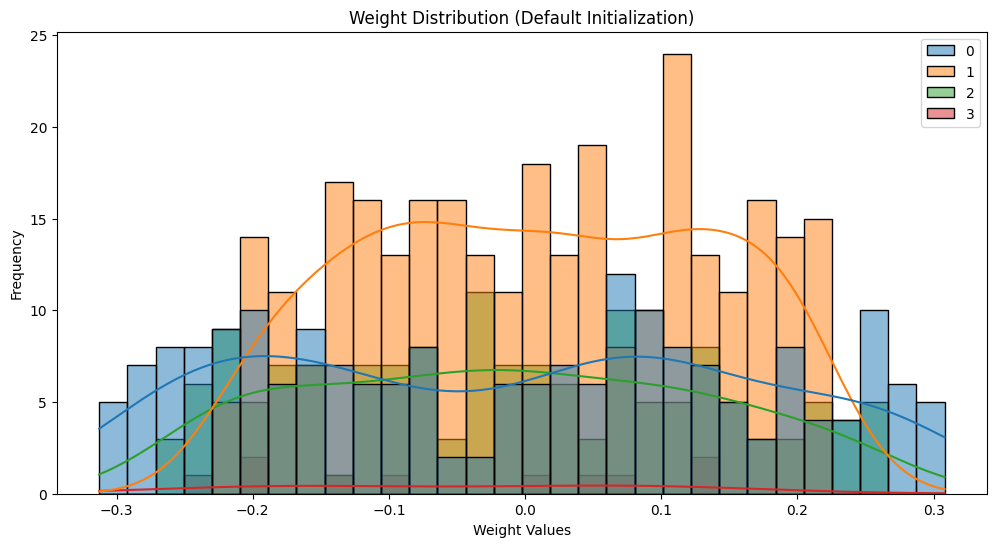

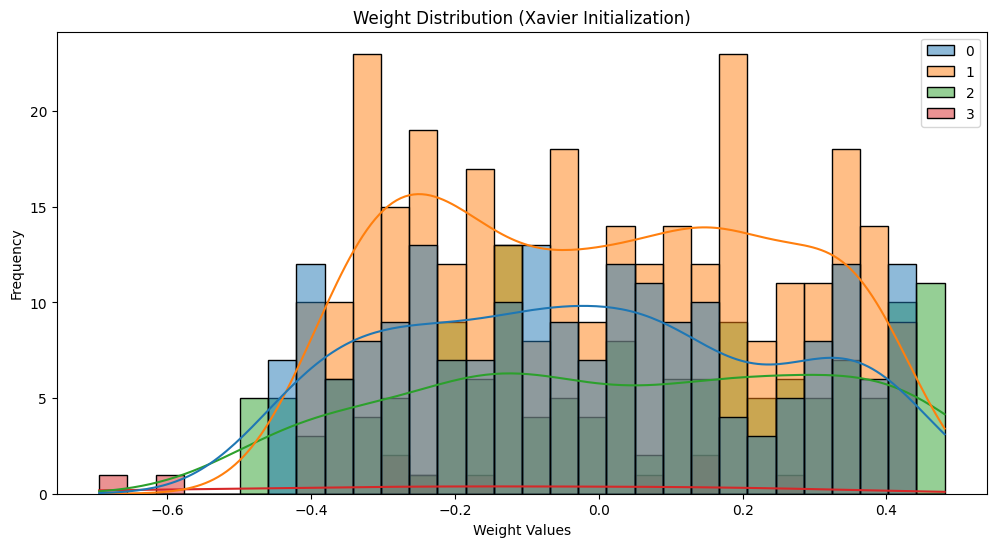

In [78]:
##initialize model
input_size = 10
hidden_sizes = [20, 15, 10]
output_size = 1
model = MyRegressor(input_size, hidden_sizes, output_size)

##default weight distribution
plot_weight_distribution(model, 'Weight Distribution (Default Initialization)')

##xavier initialization
for layer in model.layers:
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0)

##weight distribution post x initialization
plot_weight_distribution(model, 'Weight Distribution (Xavier Initialization)')

In [79]:
##train model
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        for features, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()


## L2 Regularization

Now, explicitly add L2 Regularization to your model (you will need to modify your loss term):

- Regularize the weights of hidden layer 3 (the shallowest hidden layer), using standard L2 regularization and a $\lambda$ factor of either $0$, $1$, or $100$.

- Train your regressor, using the default weight initialization, for 20 epochs using both $\lambda$ values

- Plot the distribution of weights for each layer under either $\lambda$ value at the end of training. Your results should resemble the following:

In [80]:
def train_model_with_l2(model, train_loader, criterion, optimizer, l2_lambda=0, epochs=20):
    model.train()
    for epoch in range(epochs):
        for features, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)

            ##L2 regularization for third layer
            l2_reg = 0
            for layer in model.layers:
                if isinstance(layer, nn.Linear) and layer != model.layers[-1]:
                    l2_reg += torch.norm(layer.weight)
            loss += l2_lambda * l2_reg
            
            loss.backward()
            optimizer.step()

##train L2 regularization
for l2_lambda in [0, 1, 100]:
    model = MyRegressor(input_size, hidden_sizes, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_model_with_l2(model, train_loader, criterion, optimizer, l2_lambda=l2_lambda, epochs=20)
    
    ##plot weight after training
    plot_weight_distribution(model, f'Weight Distribution (L2 Lambda = {l2_lambda})')
    
    ##plot weight after training
    plot_weight_distribution(model, f'Weight Distribution (L2 λ={l2_lambda})')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x14 and 10x20)

## Two Outputs

- Now let's extend our work to predict two outputs: `hwy` and `cty`
- Using your `FileDataset` class from before, create appropriate training, testing, and validation datasets and DataLoaders, using the same split sizes.
- Create a model with the following structure:

![2out_model](2output_model.png)

Using mean square error as your loss function, weight both outputs equally in terms of the overall error. Note that it would be more appropriate to normalize both outputs, but they are similar enough in scale that we can get away with omitting this step.

Note that this time you are to use *Swish* activation functions for all hidden layers.

Train the model for 20 epochs and graphically characterize performance with respect to both outputs, as follows.

In [81]:
class FileDataset(torch.utils.data.Dataset):
    def __init__(self, file_path):

        self.data = np.loadtxt(file_path, delimiter=',')
        self.X = self.data[:, :-2]
        self.y = self.data[:, -2:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [82]:
# Load your dataset
dataset = FileDataset(mpg_processed.csv)

# Split dataset into train, validation, and test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: name 'mpg_processed' is not defined

## Custom Layers

Create three custom layers:

1. `LinearClone()`
2. `NoisyLinear()`
3. `DropoutClone()`

All layers should inherit from `nn.Module`, and all should implement `__init()__` and `forward` methods.

For the particulars:

1. `LinearClone(in_dim, out_dim, bias=True)`

Basically clone the standard PyTorch Linear layer, but change the initialization scheme: Upon initialization, create a weight tensor that is initialized using **Glorot/Xavier Normal** initialization; create a bias tensor initialized to zero.

2. `NoisyLinear(in_dim, out_dim, bias=True, noise_sigma=1.0)`

Base this layer on your `LinearClone()`, but add normal random noise with mean zero and with a specified (initial) standard deviation, to the layer outputs **only when in training mode**.

Moreover, make the standard deviation of noise a *trainable parameter.*

3. `DropoutClone(p=.4)`

This layer should accept an input of arbitrary size, and set randomly set fraction $p$ to zero (default value of `p` is `0.4`). In training mode, the output of this layer is the randomly zeroed input, scaled by a factor of $1 / (1 - p)$. In evaluation mode, no inputs are zeroed, and the layer simply acts as the identity function.

**Confirm that your DropoutClone() works correctly on some test input tensor**

In [83]:
import torch
import torch.nn as nn

class LinearClone(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super(LinearClone, self).__init__()
        # Xavier Normal initialization for weights
        self.weights = nn.Parameter(torch.empty(out_dim, in_dim).normal_(0, 1))
        nn.init.xavier_normal_(self.weights)
        
        # Bias initialized to zero
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim))
        else:
            self.bias = None

    def forward(self, x):
        output = torch.matmul(x, self.weights.t())
        if self.bias is not None:
            output += self.bias
        return output


class NoisyLinear(LinearClone):
    def __init__(self, in_dim, out_dim, bias=True, noise_sigma=1.0):
        super(NoisyLinear, self).__init__(in_dim, out_dim, bias)
        self.noise_sigma = nn.Parameter(torch.tensor(noise_sigma))

    def forward(self, x):
        output = super(NoisyLinear, self).forward(x)
        if self.training:  # Add noise only in training mode
            noise = torch.randn_like(output) * self.noise_sigma
            output += noise
        return output


class DropoutClone(nn.Module):
    def __init__(self, p=0.4):
        super(DropoutClone, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:  # In training mode
            mask = (torch.rand(x.shape) > self.p).float()  # Create a mask
            return x * mask / (1 - self.p)  # Scale the output
        else:  # In evaluation mode
            return x  # Identity function

## Custom Activation Functions

Create the following three custom activation functions as classes that inherit from the `nn.Module` class:

- `LeakyReLUClone(negative_slope=0.01)`
- `Swish()` (Sigmoid Linear Unit)
- `ParameterizedSwish(beta=0.6)` with a *trainable* $\beta$ that starts with default $\beta=0.6$

- You should implement an `__init()__` and `forward` method for all three classes.


**Confirm that all activation functions give the expected behavior by plotting the outputs over a reasonable range of input values.**



In [84]:
class LinearClone(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super(LinearClone, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.bias = bias
        
        # Initialize weights using Glorot/Xavier Normal initialization
        self.weight = nn.Parameter(torch.empty(out_dim, in_dim).normal_(mean=0.0, std=1.0))
        nn.init.xavier_normal_(self.weight)
        
        if self.bias:
            self.bias_param = nn.Parameter(torch.zeros(out_dim))
        else:
            self.register_parameter('bias_param', None)

    def forward(self, x):
        if self.bias:
            return x @ self.weight.t() + self.bias_param
        return x @ self.weight.t()




In [85]:
class NoisyLinear(LinearClone):
    def __init__(self, in_dim, out_dim, bias=True, noise_sigma=1.0):
        super(NoisyLinear, self).__init__(in_dim, out_dim, bias)
        self.noise_sigma = nn.Parameter(torch.tensor(noise_sigma))

    def forward(self, x):
        output = super(NoisyLinear, self).forward(x)
        if self.training:
            noise = torch.normal(mean=0, std=self.noise_sigma, size=output.size()).to(output.device)
            output += noise
        return output


In [86]:
class DropoutClone(nn.Module):
    def __init__(self, p=0.4):
        super(DropoutClone, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            # Create a mask for dropout
            mask = (torch.rand(x.size()) > self.p).float().to(x.device)
            return x * mask / (1 - self.p)  # Scale the output
        return x  # Identity during evaluation


## Regressor With Custom Layers, Activation Functions

- Now, implement a regressor that takes in our inputs as before, and has the single output `hwy`.
- Call the class `CustomRegressor()`
- Implement the following architecture:

1. (Input)
2. `LinearClone` layer with 128 units, use `LeakyReLUClone(negative_slope=0.1)` as activation function
3. `DropoutClone(p=.2)`
4. `NoisyLinear(noise_sigma=10.0)` layer with 64 units, use `ParameterizedSwish(beta=.6)` as activation function
5. `DropoutClone(p=.2)`
6. Appropriate output layer

Then:

**1. Train the model for 20 epochs using an appropriate loss function and Adam optimizer with `lr=.01`.**

**2. Report $R^2$ on the training and testing datasets. Moreover, make predictions in both training and evaluation mode: Confirm you get different predictions/$R^2$ in the two modes.**

**3. Confirm that both the `noise_sigma` parameter for the noisy linear layer, and the `beta` parameter for the parameterized Swish activation function have changed with after training.**

In [88]:
class LeakyReLUClone(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(LeakyReLUClone, self).__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        return torch.where(x > 0, x, self.negative_slope * x)

class ParameterizedSwish(nn.Module):
    def __init__(self, beta=1.0):
        super(ParameterizedSwish, self).__init__()
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

In [95]:
class CustomRegressor(nn.Module):
    def __init__(self):
        super(CustomRegressor, self).__init__()
        self.layer1 = LinearClone(in_dim=10, out_dim=128)
        self.activation1 = LeakyReLUClone(negative_slope=0.1)
        self.dropout1 = DropoutClone(p=0.2)
        self.layer2 = NoisyLinear(in_dim=128, out_dim=64, noise_sigma=1)
        self.activation2 = ParameterizedSwish(beta=0.6)
        self.dropout2 = DropoutClone(p=0.2)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        return self.output_layer(x)

In [96]:

##layer/activation functions
class LinearClone(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True):
        super(LinearClone, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.bias = bias
        
        self.weight = nn.Parameter(torch.empty(out_dim, in_dim).normal_(mean=0.0, std=1.0))
        nn.init.xavier_normal_(self.weight)
        
        if self.bias:
            self.bias_param = nn.Parameter(torch.zeros(out_dim))
        else:
            self.register_parameter('bias_param', None)

    def forward(self, x):
        if self.bias:
            return x @ self.weight.t() + self.bias_param
        return x @ self.weight.t()

class NoisyLinear(LinearClone):
    def __init__(self, in_dim, out_dim, bias=True, noise_sigma=1.0):
        super(NoisyLinear, self).__init__(in_dim, out_dim, bias)
        self.noise_sigma = nn.Parameter(torch.tensor(noise_sigma))

    def forward(self, x):
        output = super(NoisyLinear, self).forward(x)
        if self.training:
            noise = torch.normal(mean=0, std=self.noise_sigma.item(), size=output.size()).to(output.device)
            output += noise
        return output

class DropoutClone(nn.Module):
    def __init__(self, p=0.4):
        super(DropoutClone, self).__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = (torch.rand(x.size()) > self.p).float().to(x.device)
            return x * mask / (1 - self.p)
        return x

class LeakyReLUClone(nn.Module):
    def __init__(self, negative_slope=0.01):
        super(LeakyReLUClone, self).__init__()
        self.negative_slope = negative_slope

    def forward(self, x):
        return torch.where(x > 0, x, self.negative_slope * x)

class ParameterizedSwish(nn.Module):
    def __init__(self, beta=1.0):
        super(ParameterizedSwish, self).__init__()
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

class CustomRegressor(nn.Module):
    def __init__(self):
        super(CustomRegressor, self).__init__()
        self.layer1 = LinearClone(in_dim=10, out_dim=128)
        self.activation1 = LeakyReLUClone(negative_slope=0.1)
        self.dropout1 = DropoutClone(p=0.2)
        self.layer2 = NoisyLinear(in_dim=128, out_dim=64, noise_sigma=1)
        self.activation2 = ParameterizedSwish(beta=0.6)
        self.dropout2 = DropoutClone(p=0.2)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.activation2(x)


In [97]:
##define transformation
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])

##MNIST dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [92]:
##split dataset into training/validation sets
train_size = len(mnist) - 5000
val_size = 5000
train_dataset, val_dataset = random_split(mnist, [train_size, val_size])

In [93]:
##dataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

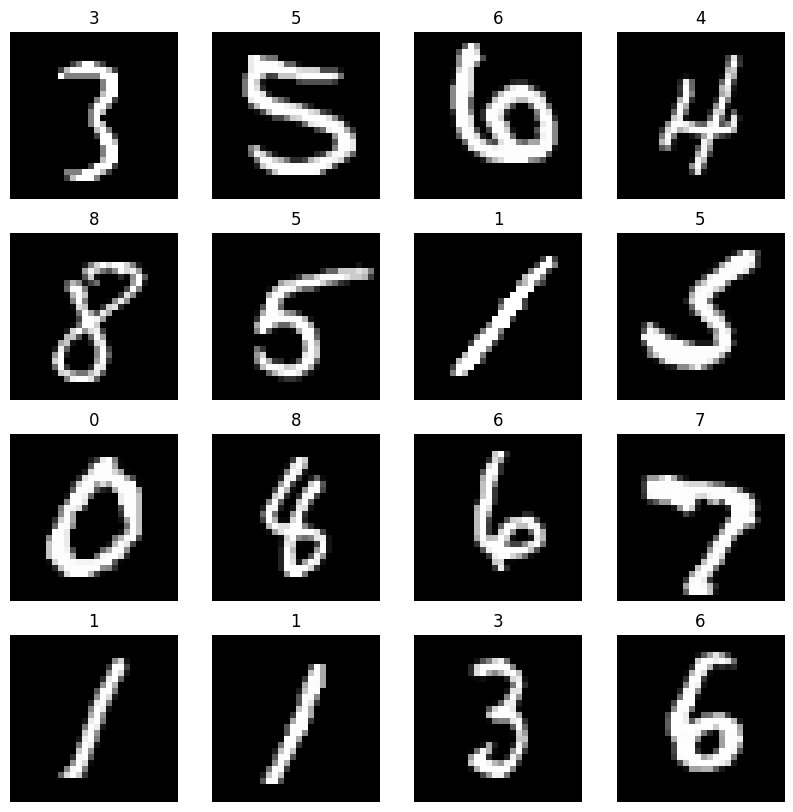

In [94]:
##first batch of validation data
val_images, val_labels = next(iter(val_loader))

def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

plot_images(val_images, val_labels)

## Basic Classifier

- Implement and train a (multi-) classifier using PyTorch to classify all 10 digits
- Call your class `MNISTClassifier()`, inherit from `nn.Module`, and define appropriate `__init__` and `forward` methods
- Use three hidden layers (use the default weight/bias initialization), all with 64 neurons, all using a *Swish* activation function
- Put a **batch normalization** layer after each of the three hidden layers
- Use an appropriate output layer and appropriate loss function
- Using the optimizer of your choice, train the model for 2 epochs

Report the final accuracy on both the training and validation datasets. ***Be sure you are in evaluation mode when calculating final accuracy.***

Plot the first batch of the validation set, along with the model prediction. Highlight any misclassifications.

In [52]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [53]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc_out = nn.Linear(64, 10)
        self.swish = Swish()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.swish(self.bn1(self.fc1(x)))
        x = self.swish(self.bn2(self.fc2(x)))
        x = self.swish(self.bn3(self.fc3(x)))
        x = self.fc_out(x)
        return x

In [54]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [55]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

##define loss function and optimizer
model = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

##train model for 2 epochs
train(model, train_loader, criterion, optimizer, epochs=2)

In [56]:
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

##calculate final accuracy
train_accuracy = evaluate(model, train_loader)
val_accuracy = evaluate(model, val_loader)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Training Accuracy: 0.9806
Validation Accuracy: 0.9728


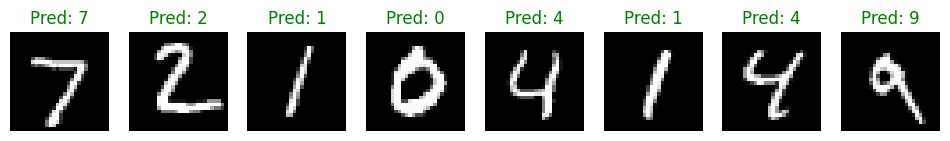

In [57]:
def plot_predictions(model, val_loader):
    model.eval()
    images, labels = next(iter(val_loader))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    ##first batch
    fig, axes = plt.subplots(1, 8, figsize=(12, 4))
    for i in range(8):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
        if predicted[i] != labels[i]:
            ax.set_title(f'Pred: {predicted[i].item()}', color='red')
        else:
            ax.set_title(f'Pred: {predicted[i].item()}', color='green')
    
    plt.show()

##predictions
plot_predictions(model, val_loader)

## Stacked Autoencoder

Implemenent a stacked autoencoder, called `MNISTAutoencoder()`, with the following architecture:

1. (Input layer with 784 units)
2. Hidden layer with 128 units
3. Hidden layer with 32 units
4. Hidden layer with 128 units
5. Output layer with 784 units

Use Swish activation functions for the hidden layers.

- Train the autoencoder to reproduce the MNIST input numbers as output.
- Train for 2 epochs, using an appropriate loss function and an Adam optimizer, with learning rate `.01`
- Plot the actual input and your output for the first 16 items of the first validation batch. Your results should resemble the following (note that output is clipped to $[0,1]$ range in the following):

In [58]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [59]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            Swish(),
            nn.Linear(128, 32),
            Swish())
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            Swish(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid() )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [60]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [61]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, _ in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

##loss function/optimizer
model = MNISTAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

##train model for 2 epochs
train(model, train_loader, criterion, optimizer, epochs=2)

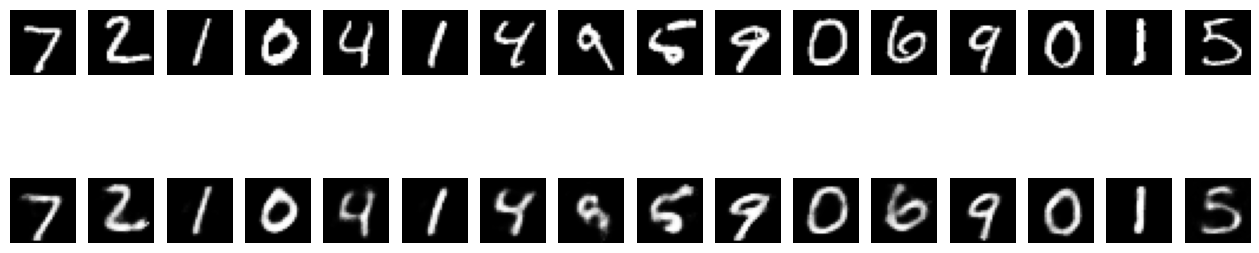

In [62]:
def plot_reconstruction(model, val_loader):
    model.eval()
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)
    with torch.no_grad():
        reconstructed = model(images)
    
    ##clip output to [0, 1]
    reconstructed = torch.clamp(reconstructed, 0, 1)
    
    ##1st 16 images
    fig, axes = plt.subplots(2, 16, figsize=(16, 4))
    for i in range(16):
        
        ax = axes[0, i]
        ax.imshow(images[i].view(28, 28).numpy(), cmap='gray')
        ax.axis('off')
        
        ax = axes[1, i]
        ax.imshow(reconstructed[i].view(28, 28).numpy(), cmap='gray')
        ax.axis('off')
        
    plt.show()

##plot
plot_reconstruction(model, val_loader)

## Transfer Learning

Use the same basic architecture as above for a classifier. However, replace the output layer with one appropriate for classifying the MNIST numbers.

1. Use the weights and biases trained by the autoencoder for all hidden layers.
2. Freeze the weights/biases of all layers, except the output layer.
3. Using an appropriate loss function and an Adam optimizer with learning rate `0.01`, train the model for 2 epochs.
4. Explicitly confirm that the weights and biases of the hidden layers did not change during training.
5. Report your final accuracy on the validation dataset.

In [63]:
class MNISTClassifier(MNISTAutoencoder):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(32, 10))

    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.classifier(encoded)
        return logits

In [64]:
def freeze_layers(model):
    for param in model.encoder.parameters():
        param.requires_grad = False

In [65]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
##classifier/freeze layers
model = MNISTClassifier()
freeze_layers(model)

##loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_classifier(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

##train classifier for 2 epochs
train_classifier(model, train_loader, criterion, optimizer, epochs=2)

In [66]:
def check_weights(model):
    for param in model.encoder.parameters():
        print(param.requires_grad)
##weights
check_weights(model)

True
True
True
True


In [67]:
def evaluate_classifier(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

##final accuracy
val_accuracy = evaluate_classifier(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.0000
